In [73]:
""" to load assets from github """
import os
if not os.path.exists("assets"):
  !git clone https://github.com/desmond-rn/assets.git
else:
    print("Data already here. Let's update it!")
    %cd assets
    # %rm -rf assets
    !git pull https://github.com/desmond-rn/assets.git
    %cd ..

!ls assets

Data already here. Let's update it!
/content/assets
From https://github.com/desmond-rn/assets
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content
dataframes  README.md


In [74]:
%reset -f

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import ast        # Pour convertir les chaines de carateres en type Python
import warnings   # Pour eviter de souvent afficher des messages d'erreurs encombrants
from itertools import cycle, islice     # technique tres importante pour generer des couleurs

Objectif du notebook:
- Nettoyer la dataframe en traitant les valeurs abérantes et manquantes
- Analyser les données quantitatives et qualitatives

# I - RETRAITEMENT DES DONNESS

## Chargeons les donnees

Les donnnes proviennent de Kaggle https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv.

In [76]:
df_0 = pd.read_csv("assets/dataframes/movie/tmdb_5000_movies.csv", thousands=',')

df_0.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [77]:
""" decrivons les donnes que nous allons utiliser par la suite """
display(df_0.dtypes)

print("\nNotre dataframe contient ", len(df_0.dtypes), "colones. Nous en creorons plus par la suite.")

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object


Notre dataframe contient  20 colones. Nous en creorons plus par la suite.


Quelques description des colones:

- **budget** : le budget du film en dollar
- **revenue**: les box-office international
- **genres** : les genres du film (par exemple action, comédie, etc..) ; un film peut bien sûr appartenir à plusieurs genres différents
- **keywords** : les mots clés associés à ce film. Il s'agit d'une particularité de ce film (adaptation d'un roman, violence, etc.)
- **overview** : l’intrigue du film
- **tagline** : le "slogan" du film (mentionné par exemple sur l'affiche)
- **original_langage** : l’unique langue originale du film ; très souvent la langue du pays de production
- **sopken_language** : les langues parlées dans le film ; les langues inconnue sont indiqués par '???????'.
- **vote_count** : le nombre de votes enregistrés par le site www.themoviedb.org
- **vote_average** : la moyenne des votes
- **popularity** : une mesure de la popularité 
- ...


In [78]:
""" supprimons les colones inutiles ou redondantes. """
df_1 = df_0.drop(["homepage", "status", "original_title"], axis=1)

## Identification des films


Transformons les id en des entiers de 1 a len(df_1)

In [79]:
for i in range(len(df_1)):
  df_1.loc[i, 'id'] = i

df_1.head(2)

,budget,genres,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",0,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",1,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


##  Millions de dolars

Exprimons les budgets et les revenus en Millions de dolars.

In [80]:
df_1["budget"] = np.round(df_1["budget"]/1e6, 3)
df_1["revenue"] = np.round(df_1["revenue"]/1e6, 3)
df_1.head(2)

,budget,genres,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
0,237.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",0,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787.965,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,Avatar,7.2,11800
1,300.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",1,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961.000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


## Suppression du fomat JSON

Recrivons les donnes en donnes non-json. Aussi, sauvegardons tous les genres, mots cles, etc. qu'on rencontre. Ces listes seront utiles pour se créer des dictionnaires bien utiles plus tard.

In [81]:
all_genres = []                         # contient tout les genres rencontres dans la dataframe, des dupliques aussi ...
all_keywords = []
all_spoken_languages = []
all_production_companies = []
all_production_countries = []

def remove_json(column):

  def func(line):
    tab = []
    items = ast.literal_eval(line[column])     # convertit le 'string' en d'autres types (liste, dico, etc..) si possible
    for item in items:
      name = item["name"]
      tab.append(name)
      if column == "genres":
        all_genres.append(name)
      elif column == "keywords":
        all_keywords.append(name)
      elif column == "spoken_languages":
        all_spoken_languages.append(name)
      elif column == "production_companies":
        all_production_companies.append(name)
      elif column == "production_countries":
        all_production_countries.append(name)
    return tab

  return func

df_1["genres"] = df_1.apply(remove_json("genres"), axis=1)
df_1["keywords"] = df_1.apply(remove_json("keywords"), axis=1)
df_1["spoken_languages"] = df_1.apply(remove_json("spoken_languages"), axis=1)
df_1["production_companies"] = df_1.apply(remove_json("production_companies"), axis=1)
df_1["production_countries"] = df_1.apply(remove_json("production_countries"), axis=1)

df_1.head(5)

,budget,genres,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
0,237.0,"[Action, Adventure, Fantasy, Science Fiction]",0,"[culture clash, future, space war, space colon...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787.965,162.0,"[English, Español]",Enter the World of Pandora.,Avatar,7.2,11800
1,300.0,"[Adventure, Fantasy, Action]",1,"[ocean, drug abuse, exotic island, east india ...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961.000,169.0,[English],"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245.0,"[Action, Adventure, Crime]",2,"[spy, based on novel, secret agent, sequel, mi...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880.675,148.0,"[Français, English, Español, Italiano, Deutsch]",A Plan No One Escapes,Spectre,6.3,4466
3,250.0,"[Action, Crime, Drama, Thriller]",3,"[dc comics, crime fighter, terrorist, secret i...",en,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084.939,165.0,[English],The Legend Ends,The Dark Knight Rises,7.6,9106
4,260.0,"[Action, Adventure, Science Fiction]",4,"[based on novel, mars, medallion, space travel...",en,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284.139,132.0,[English],"Lost in our world, found in another.",John Carter,6.1,2124


Creons des dictionnaires a partir des listes des genres, mots cles , etc.

In [82]:
""" On attribue a chaque genre, mot cle ou compagnie de production un indice entier commencant a 0 """
genres_to_id = dict()                 # conient les 'genres' comme cle, et des 'id' comme valeurs
keywords_to_id = dict()
spoken_languages_to_id = dict()
production_companies_to_id = dict()
production_countries_to_id = dict()

i = 1                                     # le 0 est reserve
for el in all_genres:
  if genres_to_id.get(el, -1) == -1:      # element absent du dico
    genres_to_id[el] = i
    i += 1

i = 1
for el in all_keywords:
  if keywords_to_id.get(el, -1) == -1:
    keywords_to_id[el] = i
    i += 1

i = 1
for el in all_spoken_languages:
  if spoken_languages_to_id.get(el, -1) == -1:
    spoken_languages_to_id[el] = i
    i += 1

i = 1
for el in all_production_companies:
  if production_companies_to_id.get(el, -1) == -1:
    production_companies_to_id[el] = i
    i += 1

i = 1
for el in all_production_countries:
  if production_countries_to_id.get(el, -1) == -1:
    production_countries_to_id[el] = i
    i += 1

print("les genres:                  ", genres_to_id)
print("les mots cles:               ", keywords_to_id)
print("les langues parlees:         ", spoken_languages_to_id)
print("les compagnies de production:", production_companies_to_id)
print("les pays de production:      ", production_countries_to_id)

les genres:                   {'Action': 1, 'Adventure': 2, 'Fantasy': 3, 'Science Fiction': 4, 'Crime': 5, 'Drama': 6, 'Thriller': 7, 'Animation': 8, 'Family': 9, 'Western': 10, 'Comedy': 11, 'Romance': 12, 'Horror': 13, 'Mystery': 14, 'History': 15, 'War': 16, 'Music': 17, 'Documentary': 18, 'Foreign': 19, 'TV Movie': 20}
les mots cles:                {'culture clash': 1, 'future': 2, 'space war': 3, 'space colony': 4, 'society': 5, 'space travel': 6, 'futuristic': 7, 'romance': 8, 'space': 9, 'alien': 10, 'tribe': 11, 'alien planet': 12, 'cgi': 13, 'marine': 14, 'soldier': 15, 'battle': 16, 'love affair': 17, 'anti war': 18, 'power relations': 19, 'mind and soul': 20, '3d': 21, 'ocean': 22, 'drug abuse': 23, 'exotic island': 24, 'east india trading company': 25, "love of one's life": 26, 'traitor': 27, 'shipwreck': 28, 'strong woman': 29, 'ship': 30, 'alliance': 31, 'calypso': 32, 'afterlife': 33, 'fighter': 34, 'pirate': 35, 'swashbuckler': 36, 'aftercreditsstinger': 37, 'spy': 38,

## Valeurs manquantes, inconnues et aberantes

### Des intrigues manquants

In [83]:
""" Les donnes manquantes  """
print("\nValeurs manquantes:")
display(df_1.apply(lambda col: sum(col.isnull()), axis=0))


Valeurs manquantes:


budget                    0
genres                    0
id                        0
keywords                  0
original_language         0
overview                  3
popularity                0
production_companies      0
production_countries      0
release_date              1
revenue                   0
runtime                   2
spoken_languages          0
tagline                 844
title                     0
vote_average              0
vote_count                0
dtype: int64

L'intrigue du film sera tres important pour notre algo d'apprentissage. Par contre la tagline ne sera pas utile. On va donc tolerer les films sans tagline mais supprimer les films sans intrigue.

In [84]:
print("Les films sans intrigues:")
display(df_1.loc[:, "title"][df_1["overview"].isnull()])

# l'intriigues etant tres importante, supprimons ces films
df_1.dropna(subset=['overview'], how='any', inplace=True)

print("\nValeurs manquantes dans 'df_1':")
display(df_1[['overview', 'tagline']].apply(lambda col: sum(col.isnull()), axis=0))

Les films sans intrigues:


2656    Chiamatemi Francesco - Il Papa della gente
4140                   To Be Frank, Sinatra at 100
4431                                   Food Chains
Name: title, dtype: object


Valeurs manquantes dans 'df_1':


overview      0
tagline     841
dtype: int64

### Des langues inconnues

In [85]:
""" Des valeurs inconnus.  La langue d'un des film parait inconnue """

unkonwn = []
def find_unkonwn(line):
  if '??????' in line['spoken_languages']:
    unkonwn.append(line['id'])              # on recupere son 'id' 
  return line

df_1 = df_1.apply(find_unkonwn, axis=1)     # la 'df_1' reste inchangee

print("les films de langue inconnue:")
for i in unkonwn:
  delete = df_1.index[df_1["id"] == i].tolist()
  display(df_1.loc[delete, :])
  # df_1.drop(delete, inplace=True)         # neamoins, on garde ce film

les films de langue inconnue:


,budget,genres,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
4275,0.0,"[Drama, Action]",4275,[biography],ky,At a time when most females in Asia possess li...,0.077873,"[Kirghizfilm, Aitysh Film]",[Kyrgyz Republic],2014-08-22,0.0,135.0,[??????],NaN,Queen of the Mountains,0.0,0


Les langues seront importantes pour la prediction qui va suivre. Mais le films a l'air super interressant (Action, Drame). On le garde !   

### Des budgets, revenus ou runtimes aberants

In [86]:
""" Verifions d'abord les limites superieres """

budget_max = 380.0              # 'Pirates of the Caribbean: On Stranger Tides'	en 2011
revenue_max = 2798.0            # 'Avengers: Endgame' l'anne derniere
runtime_max = 51420.0           # 'Logistics', un film qui a durer 35 jours (LOL) voir Wikipedia [https://en.wikipedia.org/wiki/List_of_longest_films]

print("Nombre de films a budget anormalement eleve: ", len(df_1[df_1['budget'] > budget_max]))
print("Nombre de films a revenu anormalement eleve: ", len(df_1[df_1['revenue'] > revenue_max]))
print("Nombre de films a duree anormalement elevee: ", len(df_1[df_1['runtime'] > runtime_max]))

Nombre de films a budget anormalement eleve:  0
Nombre de films a revenu anormalement eleve:  0
Nombre de films a duree anormalement elevee:  0


Genial! On n'aura pas a s'inquieter pour les limites superieures. Malheuresement pour nos donnees, il y a des films qui ont un budget, un revenue, ou un runtime vraiment trop petit.

In [87]:
""" On dispose aussi de beacoup de donnnes inexplicablement petits! (budget, revenus, et runtime).  """

cond1 = df_1['budget'] < 1e-3
cond2 = df_1['revenue'] < 1e-3
cond3 = df_1['runtime'] < 1

print("Nombre de films a budget inferieur a 1000 dolards:", len(df_1.loc[cond1]))
print("Nombre de films a revenu inferieur a 1000 dolards:", len(df_1.loc[cond2]))
print("Nombre de films a duree inferieure a 1 minute:", len(df_1.loc[cond3]))

outliers = df_1.loc[cond1 | cond2 | cond3].index    # retenons les indices de tous les films aberants
print("\nTotal de films avec budget ou revenu ou runtime aberants:", len(outliers))

Nombre de films a budget inferieur a 1000 dolards: 1067
Nombre de films a revenu inferieur a 1000 dolards: 1445
Nombre de films a duree inferieure a 1 minute: 35

Total de films avec budget ou revenu ou runtime aberants: 1589


Il y a vraiment beacoup de films a budget ou revenus ou runtime trop petits (1589), mais ca serait vraiment douleureux de tous les supprimer. On décide dans un premier temps de **remplacer ces valeurs aberantes par les moyenne des budget et des revenus**.   

In [88]:
""" Effectuons le rempalcemtn """
budget_bar = np.mean(df_1['budget'])
revenue_bar = np.mean(df_1['revenue'])
runtime_bar = np.mean(df_1['runtime'])

def replace_zeros(line):
  if line['budget'] < 1e-3:
    line['budget'] = budget_bar
    line['revenue'] = revenue_bar       # si on remplace le budget, on remplace aussi le revenu
  if line['revenue'] < 1e-3:
    line['revenue'] = revenue_bar
    line['budget'] = budget_bar         # si on remplace le revenu, on remplace aussi le budget
  if line['runtime'] < 1:
    line['runtime'] = revenue_bar
  return line

df_1 = df_1.apply(replace_zeros, axis=1)

print("Nombre de films a budget aberants dans 'df_1':", len(df_1[df_1['budget'] < 1e-3]))
print("Nombre de films a revenu aberants dans 'df_1':", len(df_1[df_1['revenue'] < 1e-3]))
print("Nombre de films a duree aberante dans 'df_1':", len(df_1[df_1['runtime'] < 1]))

print("\nA la fin du traitement, on dispose de", len(df_1), "lignes utilisables. Pas mal!")

Nombre de films a budget aberants dans 'df_1': 0
Nombre de films a revenu aberants dans 'df_1': 0
Nombre de films a duree aberante dans 'df_1': 0

A la fin du traitement, on dispose de 4800 lignes utilisables. Pas mal!


## Créations de nouvelles variables

### Des dummy variables pour le genre

In [89]:
""" Tout d'abord, reorganisons les colonnes pour plus de lisibilite """
df_1 = df_1[["id", "title", "release_date", "tagline", "overview", "keywords", "genres", "runtime", "budget", "revenue", "popularity", "vote_average", "vote_count", "production_countries", "original_language", "spoken_languages", "production_companies"]]
df_1.head(1)

,id,title,release_date,tagline,overview,keywords,genres,runtime,budget,revenue,popularity,vote_average,vote_count,production_countries,original_language,spoken_languages,production_companies
0,0,Avatar,2009-12-10,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]",162.0,237.0,2787.965,150.437577,7.2,11800,"[United States of America, United Kingdom]",en,"[English, Español]","[Ingenious Film Partners, Twentieth Century Fo..."


Dans la suite, il nous sera nécessaire d'analyser les corrélations entre différents genres de films. Mais les genres sont qualitatifs. Nous allons donc créer des variables muettes correspondant à chacun des genres de films qu’on rencontre dans la data frame. Ces dummies seront la cible du premier apprentissage que nous allons effecteur dans le notebook suivant(classification multi-label).

In [90]:
""" Une dummy variable pour chaque genre """
for genre in genres_to_id.keys():     # 'genres_to_id' est le dico contenant tous nos genres
  df_1[genre] = 0

""" Remplissons les dummies """
def fill_dummies(line):
  for genre in line["genres"]:
    line[genre] = 1
  return line

df_1 = df_1.apply(fill_dummies, axis=1)

columns_to_print = [1, 6] + list((np.arange(len(genres_to_id)) + 17))      # Affchons juste les titres et les nouvelles colonnes
df_1.iloc[:5, columns_to_print]

,title,genres,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Spectre,"[Action, Adventure, Crime]",1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,John Carter,"[Action, Adventure, Science Fiction]",1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Un meilleur indicateur du succès ou de l'echec

Il nous faut une métrique pour définir le succès ou l'échec d'un film. On décrète qu'il s'agit d'un :
- **échec** s'il rapporte moins que son budget ; ou s'il rapporte moins d' 1.25 fois son budget alors que ce budget était très grand (supérieur à 100 millions de dollars).
- **succès massif** (ou **retentissant**) s'il rapporte plus de 10 fois son budget ; ou s'il rapporte plus de 350 millions de dollars, ayant nécessité au plus le tiers de cela.
- **succès** dans tous les autres cas.   

Ces catégories seront la cible du deuxième apprentissage que nous allons effectuer (classification multi-classe).


In [91]:
""" creons des categories pour les succes ('return') des films """
df_1['return'] = df_1['revenue'] / df_1['budget']
df_1['return_type'] = pd.cut(df_1['return'], bins=[0, 1, 10, max(df_1['return'])], right=True, labels=["failure", "success", "massive success"])    # Attention, les ratios pour les 'bins' sont pris un peu au hazard

""" Pour les films a gros budgets ==> gros risques ==> on est plus tolerant dans la definition du succès massif et severe dans la definition de l'echec """
def adjust_return_type(line):
  if (line['revenue'] > 350 and line['return'] > 3):
    line['return_type'] = 'massive success'
  if (line['budget'] > 100 and line['return'] < 1.25):
    line['return_type'] = 'failure'
  return line

df_1 = df_1.apply(adjust_return_type, axis=1)

""" au final, on a """ 
df_1['return_type'].value_counts()

success            3567
failure             795
massive success     438
Name: return_type, dtype: int64

C'est tres déséquilibré pour un algo d'apprentissage. Neanmoins, on avance!

In [92]:
""" Reoarganizons les colones. On insere les'return' et 'return_type' juste apres les revenus """
cols = list(df_1.columns)
if cols[-1] == 'return_type':                                                                 # ca devient tres vite confus si 'return_type' n'est pas la derniere colonne
  cols = cols[:10] + [cols[-2], cols[-1]] + cols[10:]
  cols = cols[:-2]
  df_1 = df_1[cols]

print("Les 3 plus gros films a succes:")
df_1.sort_values(by=['return'], ascending=False).head(3)

# print("les 3 plus gros echecs:")
# df_1.sort_values(by=['return'], ascending=True).head(3)

Les 3 plus gros films a succes:


,id,title,release_date,tagline,overview,keywords,genres,runtime,budget,revenue,return,return_type,popularity,vote_average,vote_count,production_countries,original_language,spoken_languages,production_companies,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
4577,4577,Paranormal Activity,2007-09-14,What Happens When You Sleep?,"After a young, middle class couple moves into ...","[haunting, psychic, entity, demonic possession...","[Horror, Mystery]",86.0,0.015,193.356,12890.400000,massive success,47.456823,5.9,1316,[United States of America],en,[English],"[Blumhouse Productions, Solana Films]",0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4496,4496,The Blair Witch Project,1999-07-14,The scariest movie of all time is a true story.,In October of 1994 three student filmmakers di...,"[witch, voodoo, legend, sorcery, maryland, for...","[Horror, Mystery]",81.0,0.060,248.000,4133.333333,massive success,41.690578,6.3,1055,[United States of America],en,[English],"[Artisan Entertainment, Haxan Films]",0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4724,4724,Eraserhead,1977-03-19,Where your nightmares end...,Henry Spencer tries to survive his industrial ...,"[baby, mutant, claustrophobia, nightmare, pare...","[Drama, Fantasy, Horror, Science Fiction]",89.0,0.010,7.000,700.000000,massive success,20.399578,7.5,485,[United States of America],en,[English],"[American Film Institute (AFI), Libra Films]",0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Bizarrement ce sont tous des films d'horreur à très faible budget. Les gens aiment-ils tant les films d'horreur que ça ? Mais plus important : est-ce là la solution pour percer dans l'industrie du cinéma ????

## Une dataframe plus stricte

In [93]:
""" Si on veut plus de repcison dans notre etude. On peut utiliser 'df_2'. Dedans on a supprime toutes le valeurs qui etaient aberantes dans df_2 """
df_2 = df_1.drop(index=outliers)

print("Nombre de films dans 'df_1':", len(df_1))
print("Nombre de films dans 'df_2':", len(df_2))

Nombre de films dans 'df_1': 4800
Nombre de films dans 'df_2': 3211


- La `df_1` est plus riche mais moins fiable vu que les valeurs aberantes (budget, revenu, et duree) furent remplacées par les moyennes. Cependant, nous n'y avons modifié aucune intrigue et aucun genre. Nous pouvons donc utiliser cette dataframe pour la prediction du genre a partir des intrigues.  
- La `df_2` est moins riche mais plus fiable.  En ce qui concerne l'appretissage, elle nous servira dans la prediciton du succes à partir du budget, de la duree, du genre, des mots cles, des compagnies de production et des langues parlées. 


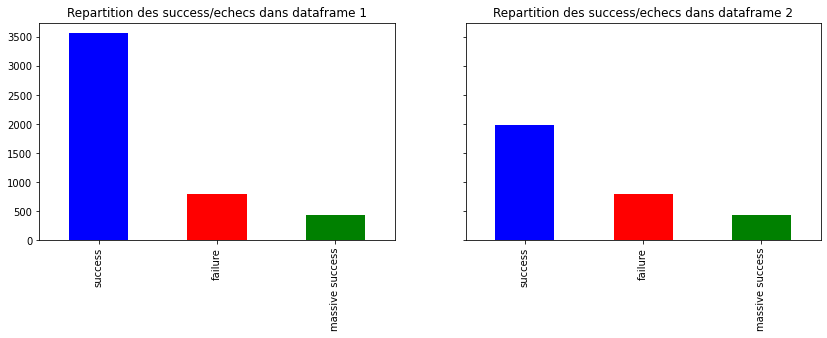

In [94]:
""" Observons la repartition des return_type des films dans ces dataframes """
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 4))
df_1['return_type'].value_counts().plot(ax=ax[0], kind='bar', color=['b', 'r', 'g'], title="Repartition des success/echecs dans dataframe 1")
df_2['return_type'].value_counts().plot(ax=ax[1], kind='bar', color=['b', 'r', 'g'], title="Repartition des success/echecs dans dataframe 2");

La df_2 est mieux équilibrée que la df_1 (même si elle n’est pas aussi riche). Ceci nous donne une motivation supplémentaire pour utiliser df_2 lors de la prédiction du succès des films.


**Dans la suite de ce notebook, sauf indication contraire, nous utiliserons la `df_1` pour l'annalyse des variables `qualitatives` MAIS `df_2` pour l'analyse des varaibles `quantitatives`**.

# III - ANALYSE DES VARIABLES QUALITATIVES

Pour cette section, nous utilisons le jeu de donnees `df_1` car plus riche.

## Analyse du genre des films

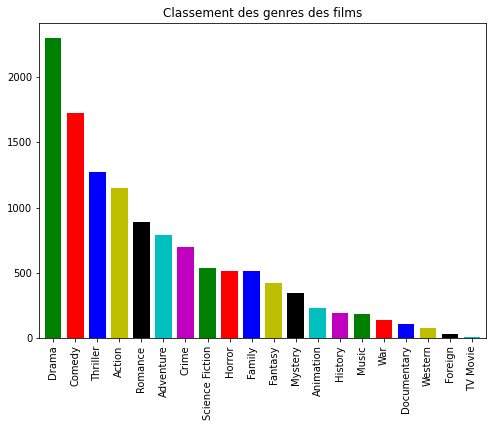

In [95]:
""" On traite les genres comme une variable qualitative"""

y = []    # contient les occurence de chaque genre
for genres in df_1["genres"]:
  for genre in genres:
    y.append(genre)

# Travaillons avec des series et des dataframes, c'est plus rapide
s_y = pd.Series(y).value_counts()

colors = list(islice(cycle(['g', 'r', 'b', 'y', 'k', 'c', 'm']), None, len(df_1)))
s_y.plot(kind='bar', width=0.75, figsize=(8,5.8), color=colors, title="Classement des genres des films");

Beaucoup de films se considèrent comme des **drames**. C’est normal car la définition d’un drame n’est pas du tout rigoureuse. À l'opposé personne ne veut faire des films destinés au **petit écran**. C’est aussi normal car la principale source de revenu du film (son box-office) est alors supprimée.

## Analyse des compagnies de production

On connait tous les titans de l'industrie du cinéma (le "Big Five” : Universal, Paramount, Warner Bros., Walt Disney, et Columbia). Mais quelle sont ces compagnies qui investissent le plus sagement, faisant ainsi des bons films de façon consistante. Je soupçonne **Pixar** et **Marvel** ; il parait qu'ils ne font jamais de mauvais films.

Exceptionnellemnt, on devrait utiliser la df_2 car le succes (qui est une valeur approximée dans df_1) est impliqué ici.

In [96]:
""" une fonction pour plotter les 10 plus grosses compagnies (en frequence) associees impliquues dans les success/échec """
def plot_companies_ranking(ax, df, type, top, number_to_plot): 
  y = []                            # contient les occurence pour ce type de chaque compagnie
  y_total = []                      # contient les occurence pour les tous les 3 types de chaque compagnie
  for i in list(df['id']):
    for el in df.loc[i, "production_companies"]:
        y_total.append(el)
        if df.loc[i, "return_type"] == type:
          y.append(el)

  df_y = pd.DataFrame({"involvements":y})
  df_y = pd.DataFrame(df_y['involvements'].value_counts()).sort_index()

  df_y_total = pd.DataFrame({"involvements":y_total})
  df_y_total = pd.DataFrame(df_y_total['involvements'].value_counts())
  df_y_total = df_y_total.loc[df_y.index, :].sort_index()                               # on veut celles qui sont aussi dans y

  df_y['frequencies'] = df_y['involvements'] / df_y_total['involvements']
  df_y = df_y.sort_values(by='involvements', ascending=False).iloc[:top, :]             # on etudie les "top" premiers en nombre de d'implication dans les films
  df_y = df_y.sort_values(by='frequencies', ascending=False).iloc[:number_to_plot, :]   # mais on ne plot que les "number_to_plot" premiers en frequence

  df_y['frequencies'].plot(ax=ax[0], kind='bar', color=colors, title="fréquence")
  df_y['involvements'].plot(ax=ax[1], kind='bar', color=colors, title="nombre d'imlications");

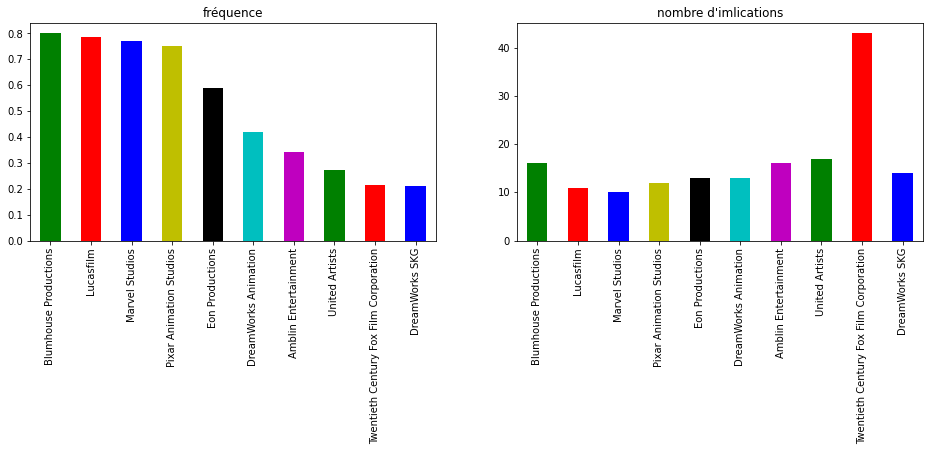

In [97]:
""" Analyse des succes du top 20 """
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plot_companies_ranking(ax, df_2, "massive success", 20, 10)

Dans le top 20 des compagnies qui font le plus de films à succès massif :
- **Pixar** et ses films d'animation est 4ème en termes de fréquence (consistance) de production de ces magnifiques films ; L'univers Cinématique de **Marvel** est aussi bien classé en 3ème position. Mes suspicions (et celles du public) sont bien correctes sur ce point.
- Ça ne me surprend pas que **Lucasfilm** soit 2ème, vu que les films Star Wars "rapporteront toujours de l'argent", qu'ils restent bons ou pas.
- Je suis cependant très surpris par **Blumhouse Productions**. Je n'avais aucune idée qu'ils étaient aussi chirurgicaux. D'après leur portfolio, Blumhouse semble spécialisé dans les films d'horreur, ce qui confirme l'intuition que j’ai eu lorsque j’observais les 3 plus grand films à succès. Est-ce que mon algorithme d’apprentissage réussira à capter leur recette sécrète ?


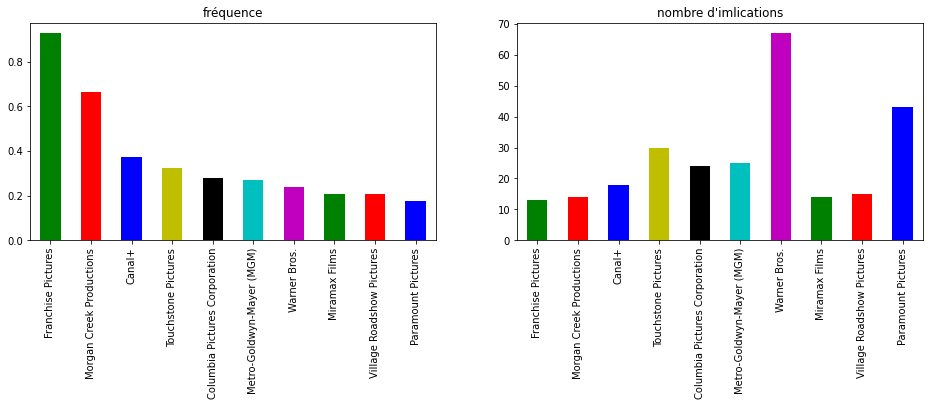

In [98]:
""" Analyse des echechs du top 15 """
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
plot_companies_ranking(ax, df_2, "failure", 15, 10)

Je suis assez surpris de retrouver Warner Bros. et Canal+ dans cette ce top 15. C'est trop triste ! DC (et son parent Warner Bros.) a intérêt à redoubler d'efforts pour rattraper Marvel (et son parent Disney).

## Analyse des langues des films

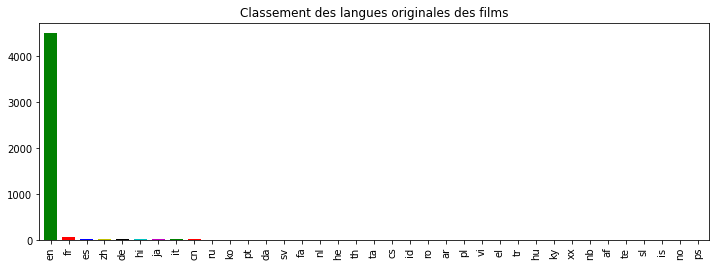

In [99]:
""" Regardons les langues originales. un films n'a qu'une seule langue originale, donc c'est facile! """
s_y = df_1['original_language'].value_counts()

s_y.plot(kind='bar', width=0.75, figsize=(12,4), color=colors, title="Classement des langues originales des films");

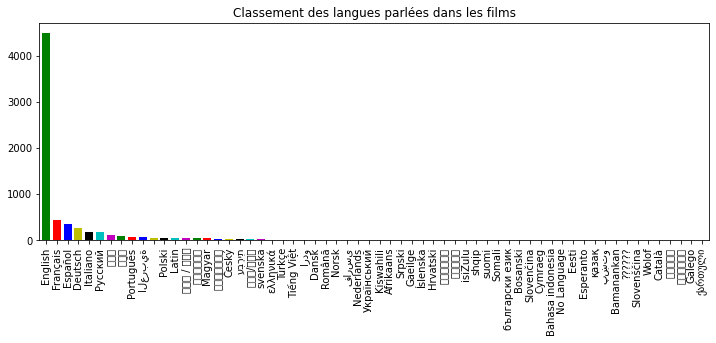

In [100]:
""" Regardons maintenant les langues qui figurent dans les films. Il peut y en avoir plusieurs pour un seul film """
y = []  # contient les occurence de chaque langue
for languages in df_1["spoken_languages"]:
  for language in languages:
    y.append(language)

warnings.filterwarnings("ignore")         # desactivons les warnings, vu qu'on affiche des characteres non-ascii

s_y = pd.Series(y).value_counts()
s_y.plot(kind='bar', width=0.75, figsize=(12,4), color=colors, title="Classement des langues parlées dans les films");
plt.show()

warnings.filterwarnings("always")         # reactivons les warnings

La majorité des films dans notre data frame étant Hollywoodien, naturellement l'anglais domine. On y trouve quand même quelques films français (langue originale = **fr**). On rencontre encore plus de films qui emploient le français (langue parlée = **Français**), qu’ils soient made in France ou non. Ça confirme bien le fait que le français est une langue bien aimée des Américains.

## Analyse des mots cles

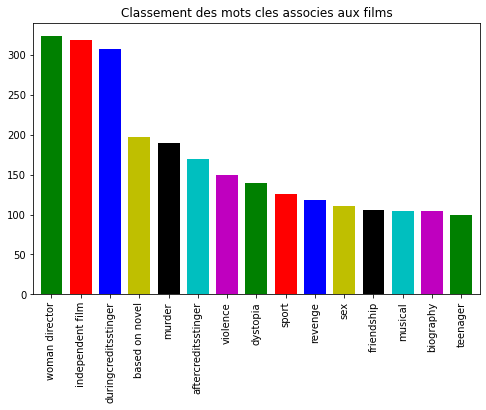

In [101]:
""" pour plotter les 15 mots cles les plus recurents """
y = []
for el in df_1["keywords"]:
    y += el

s_y = pd.Series(y).value_counts()[:15]
s_y.plot(kind='bar', width=0.75, figsize=(8,5), color=colors, title="Classement des mots cles associes aux films");

- Certains de ces mots clés étaient prévisibles. Par exemple "**during credits stinger**" et "**after credits stinger**". S'il y a une scène pendant ou après le générique de fin, il vaudrait mieux être averti avant d'aller au cinéma. Aussi, c’est normal d’avoir "**independent film**" dans cette liste. Les réalisateurs ont généralement plus de liberté sur ces films. On s’attend alors à une "vrai" expérience artistique.
- Par contre je suis un peu choqué par la mention "**woman director**" si fréquente. Il faut tout simplement croire que nos données ont un petit problème de sexisme. Après tout, certains de ces films remontent à la création du cinéma.


# II - ANALYSE DES VARIABLES QUANTITATIVES

Dans cette section, nous utilisons la `df_2` car plus fiables dans ses données numériques.

## Tableau de correlations

In [102]:
corr = df_2.iloc[:, 1:].corr()      # on exclu l'id de l'etude des correlations

corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all')   # on supprimes les NaN car certaines varainces peuvent etre non-nulles ('TV Movie')...
corr.iloc[:10, :10]

,runtime,budget,revenue,return,popularity,vote_average,vote_count,Action,Adventure,Fantasy
runtime,1.000000,0.227734,0.231960,-0.033185,0.180934,0.382458,0.257155,0.062402,0.071508,-0.021543
budget,0.227734,1.000000,0.704625,-0.031261,0.430456,-0.030936,0.539020,0.308825,0.413868,0.271574
revenue,0.231960,0.704625,1.000000,0.013569,0.601410,0.188893,0.755727,0.187710,0.343679,0.216337
return,-0.033185,-0.031261,0.013569,1.000000,0.013373,0.000372,0.007241,-0.019864,-0.014159,-0.007628
popularity,0.180934,0.430456,0.601410,0.013373,1.000000,0.288329,0.748540,0.142373,0.229920,0.131728
vote_average,0.382458,-0.030936,0.188893,0.000372,0.288329,1.000000,0.379315,-0.129945,-0.042924,-0.056126
vote_count,0.257155,0.539020,0.755727,0.007241,0.748540,0.379315,1.000000,0.188155,0.253551,0.152031
Action,0.062402,0.308825,0.187710,-0.019864,0.142373,-0.129945,0.188155,1.000000,0.363537,0.066799
Adventure,0.071508,0.413868,0.343679,-0.014159,0.229920,-0.042924,0.253551,0.363537,1.000000,0.242416
Fantasy,-0.021543,0.271574,0.216337,-0.007628,0.131728,-0.056126,0.152031,0.066799,0.242416,1.000000


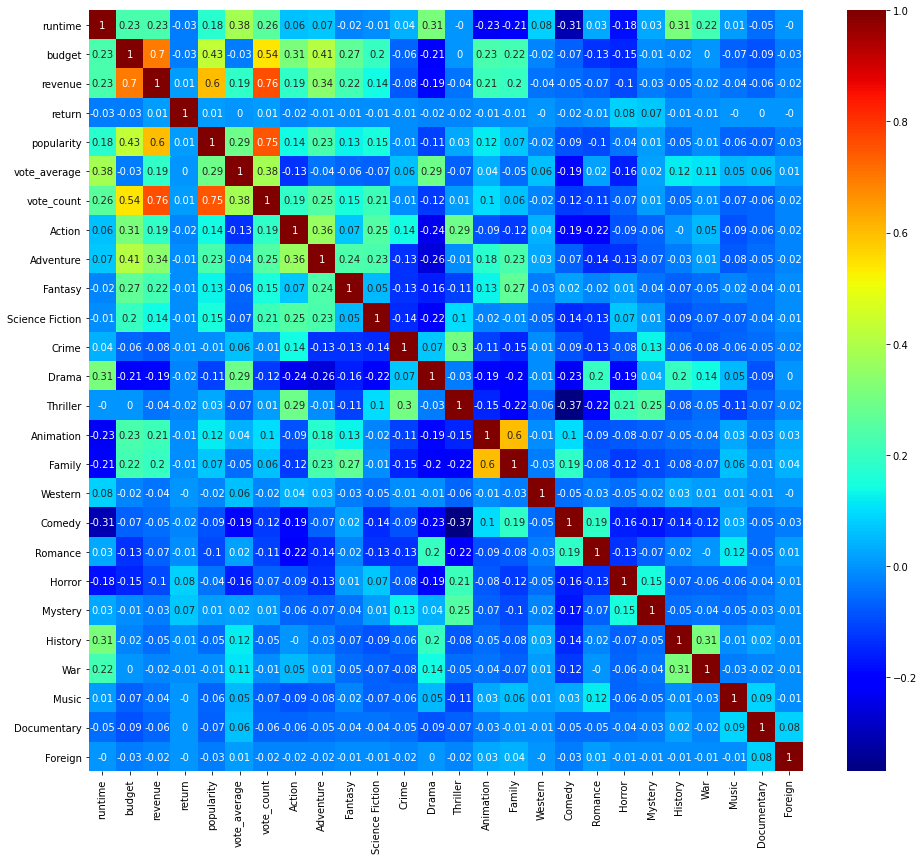

In [103]:
plt.figure(1,figsize=(16,14))
sb.heatmap(np.round(corr,2), annot=True, cmap="jet");

In [104]:
"""les 30 couples les plus correles"""
values = corr.values
names = corr.index

n=len(values)
corr_list=[]
for i in range(n):
    for j in range(n):
        if i < j:
            corr_list.append((np.round(values[i,j],3), names[i], names[j]))
corr_list.sort(key=lambda triplet:-triplet[0])   

corr_list[:30]

[(0.756, 'revenue', 'vote_count'),
 (0.749, 'popularity', 'vote_count'),
 (0.705, 'budget', 'revenue'),
 (0.601, 'revenue', 'popularity'),
 (0.597, 'Animation', 'Family'),
 (0.539, 'budget', 'vote_count'),
 (0.43, 'budget', 'popularity'),
 (0.414, 'budget', 'Adventure'),
 (0.382, 'runtime', 'vote_average'),
 (0.379, 'vote_average', 'vote_count'),
 (0.364, 'Action', 'Adventure'),
 (0.344, 'revenue', 'Adventure'),
 (0.315, 'History', 'War'),
 (0.311, 'runtime', 'History'),
 (0.31, 'runtime', 'Drama'),
 (0.309, 'budget', 'Action'),
 (0.302, 'Crime', 'Thriller'),
 (0.291, 'vote_average', 'Drama'),
 (0.291, 'Action', 'Thriller'),
 (0.288, 'popularity', 'vote_average'),
 (0.272, 'budget', 'Fantasy'),
 (0.272, 'Fantasy', 'Family'),
 (0.257, 'runtime', 'vote_count'),
 (0.254, 'vote_count', 'Adventure'),
 (0.252, 'Action', 'Science Fiction'),
 (0.249, 'Thriller', 'Mystery'),
 (0.242, 'Adventure', 'Fantasy'),
 (0.234, 'Adventure', 'Science Fiction'),
 (0.232, 'runtime', 'revenue'),
 (0.231, 'Adv

__On voit sans surprise que__
- Les films à gros revenu ont tendance à avoir un gros budget et sont les plus votés.
- Ces films à grand nombre de votes deviennent naturellement les plus populaires. Ceci indique que, les votes (quand ils effectués) ont tendance à être favorables.
- Les films d’aventure ont tendance à contenir de l’action
- Les films d'histoire sont très souvent des films de guerre. C'est la nature belliqueuse de l'homme.


__Mais a ma grande surprise__
- Les films d'animation sont très souvent les films de famille. De nos jours, les animés (surtout japonais) viennent sous toutes les formes. Je me disais que cela équilibrerait un peu les choses.
- Le budget est un meilleur indicateur du genre Adventure que du genre Action (tous deux ayant tendance à couter cher). C'est probablement dû au fait que les films d’action ne sont pas très bien définis, alors que les films d’aventure le sont.



In [105]:
""" Les 5 couples les moins correles """ 
corr_list[-6:]

[(-0.226, 'runtime', 'Animation'),
 (-0.233, 'Drama', 'Comedy'),
 (-0.238, 'Action', 'Drama'),
 (-0.256, 'Adventure', 'Drama'),
 (-0.307, 'runtime', 'Comedy'),
 (-0.367, 'Thriller', 'Comedy')]

C'est **assez normal** car: 
- Un film à suspense (Thriller) est très difficilement amusant !
- Les films d'animation et de comédie ont un temps réduit. C'est normal car les enfants ont une durée d'attention faible.



Cependant, l'information la plus importante confirmée par le tableau de corrélation est que les **return** **= revenue/budget** ne sont pas du tout corrélés avec le **budget**. L'industrie du cinéma présente des risques. Il ne suffit pas d'investir une grosse somme pour espérer en gagner par la suite.

## Relation 'budget' - 'revenu' - 'popularité' - 'votes' - 'succes'

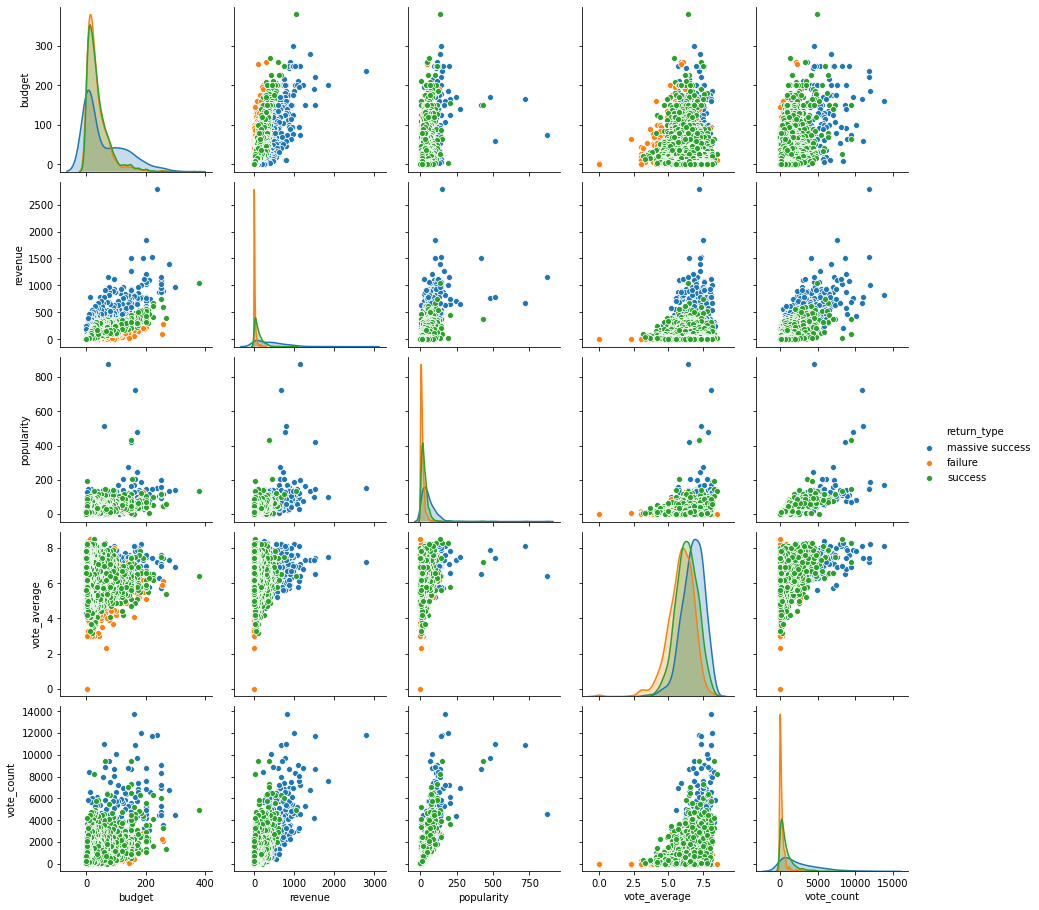

In [106]:
""" on fait le pairplot """
sb.pairplot(df_2, vars=['budget', 'revenue', 'popularity', 'vote_average', 'vote_count'], hue='return_type', corner=False);

Cette figure confirme bien que:
- Le revenu, la popularité, et le nombre de votes évoluent avec les budgets des films. (**colonne 1**). 
- En ce qui concerne la dépendance par rapport au revenu (**colonne 2**), on voit que la popularité et le nombre de vote croient avec le revenu. Tandis que la moyenne des votes a tendance à rester autour de 7. Autrement dit, même les films qui ont perdu de l'argent sont bien votés.
- La popularité est un bon prédicteur du nombre de votes (**colonne 3**).
- Il n'y a de dépendance concrète (d'aucune des autres variables) en fonction de la moyenne des votes (**colonne 4**).
- Quand le nombre de votes est fort, le budget, le revenu, la popularité, et surtout la moyenne des votes ne peuvent être qu'élevés (**colonne 5**). Ça traduit le fait qu’on risque toujours d'avoir des films nuls qui sont mis en avant par un groupe de personnes très (très) motivé (en votant plusieurs fois par exemple).


On observe les couleurs sur la figure. Elles indiquent le type du retour:  succès massif (bleu), échec (orange), ou succès (vert). 
- Les films à succès massifs n'ont pas forcément un gros budget.
- Un indicateur pour les films à succès massifs **une moyenne des votes relativement élevée** (courbe "vote_average" - "vote_average"). Ça se confirme dans la réalité : on paye les critiques pour bien noter nos films ; et puis dénigrer les films de la compétition (Marvel vs. DC). Malheureusement pour nous, la moyenne des votes est connue après la sortie du film. Nous ne pouvons donc pas l'utiliser pour la prédiction du succès.



# IV - EXPORT DES DONNEES

## Sauvegardes des dictionnaires

Sous forme de module python 3

In [107]:
file = open('movie_dico.py', 'w')

file.write('# Les dictionnaires\n')
file.write('genres_to_id = ' + str(genres_to_id) + '\n')
file.write('keywords_to_id = ' + str(keywords_to_id) + '\n')
file.write('spoken_languages_to_id = ' + str(spoken_languages_to_id) + '\n')
file.write('production_companies_to_id = ' + str(production_companies_to_id) + '\n')
file.write('production_countries_to_id = ' + str(production_countries_to_id) + '\n')

file.close()

## Sauvegarde des dataframes

Description des dataframes à saucegrader au format csv.
- df_0 : df originale
- **df_1** : df netoyée avec les valeurs aberantes remplacées par les moyennes.
- **df_2** : df netoyée avec les valeurs aberantes complètement supprimées

In [108]:
""" Exportons les donnees pour l'apprentissage """

df_1.to_csv('tmdb_5000_movies_imputed.csv', header=True)    # les donnees aberantes remplacees par les moyennes
df_2.to_csv('tmdb_5000_movies_omitted.csv', header=True)    # les donnees aberantes supprimees